# Task D:  Predictive Data Analysis using R
I need to train a machine learning model on dialogue utterance vs dialogue usefulness. 

The data files I have, with the descriptions of their columns are:
dialogue_utterance_train/validation/test.csv 
Dialogue_ID - The unique ID of a dialogue 
Usefulness_score - This score is given by a student to indicate their perceived 
usefulness of the FLoRA chatbot when answering the post-task 
questionnaire Question 3 (i.e., “To what extent do you think the 
GPT-powered chatbot on FLoRA is useful for you to accomplish 
the assignment?”). The value range of this feature is [1,5], with 1 
representing “very unuseful”, 2 representing “unuseful”, 3 
representing “neutral”, 4 representing “useful”, and 5 
representing “very useful”.

dialogue_usefulness_train/validation/test.csv
Column Name - Description 
Dialogue_ID - The unique ID of a dialogue 
Timestamp - When an utterance contained in the dialogue was made 
Interlocutor - Whether the utterance was made by the student or the chatbot ("Student"/"Chatbot")
Utterance_text - The text of the utterance

dialogue_utterance_train has 117k lines, split over 303 unique dialogue IDs.
1.  What  features  can  you  engineer  to  empower  the  training  of  a  machine  learning model? You may propose as many as you believe are useful. Please note that the number of the features should not exceed the number of the dialogues contained in the training set. Otherwise, the constructed machine learning models are prone to have overfitting issues. Select two features that you propose and try to use boxplots to visualise  the  feature  value  between  the following two groups of dialogues in the training  set:  (i)  those  with  Usefulness_score  of  1  or  2;  and  (ii)  those  with Usefulness_score  of  4  or  5.  Show if there  any  difference  between  the  two  groups  of dialogues? How can you tell whether the difference is statistically significant? Ideally, identify features that display statistically significant differences. 
 
2.  Build a machine learning model (e.g., polynomial regressions, regression tree) based on the training set by taking all the features that you have proposed and evaluate the performance of the model on the validation set using the relevant evaluation metrics you learned in class. Aim to include at least 5 features in this model. The best-performing model here is denoted as Model 1. 
3.  Now we want to improve the performance of Model 1 (i.e., to get a more accurate model).  For  example,  you  may  try  some  of the following methods to improve a model: 
●  Select  a  subset  of  the  features  (especially  the  important  ones  in  your opinions) as input to empower a machine learning model or a subset of the 
data in a dialogue (given that some questions asked by students might not be 
directly relevant to solving the assignment). 
●  Deal with errors (e.g.: filtering out data outliers). 
●  Rescale  data  (i.e.,  bringing  different  variables  with  different  scales  to  a common scale). 
●  Transform data (i.e., transforming the distribution of variables). 
●  Try other machine learning algorithms that you know. 
 
Please build the predictive models by trying some of the above methods or some other methods you can think of and evaluate the performance of the models and report whether Model 1 can be improved. 
Explain how you have improved your model by including code, output, 
and  explanations  (explaining  the  code  or the process) and justify why you have chosen some of the above methods or some other methods to improve a model 
(e.g., why this subset of the variables are chosen to build a model). 
4.  What is the Dialogue_ID of the dialogue you generated? Please copy and paste the whole  dialogue  text  that  you  generated  with  the  chatbot  here.  With  the best-performing model constructed from Question 2&3, what is the prediction value for the dialogue you generated? Is the prediction value close to the groundtruth value? 
If yes, what features do you think play important roles here to enable the model to successfully make the prediction? How can you determine the importance of features quantitatively? If not, what might be the reasons? For students whose dialogues are included in the test set, you may randomly select a dialogue from the validation set to analyse and answer this question. 
5.  The  groundtruth  Usefulness_score  values  in  the  file “dialogue_usefulness_test.csv” are unavailable now. Here, your task is to use the best-performing model constructed from Question 2&3 to predict the usefulness of the dialogues contained in the  test  set.  You  need  to  populate  your  prediction  results  (i.e.,  the  predicted Usefulness_score values) into the file “dialogue_usefulness_test.csv” and upload it to Moodle to measure the overall performance of your model. Please ensure the number of  columns  and  rows  remains  the  same  as  in  the  original  file (dialogue_usefulness_test.csv),  and  only  fill  in  the  prediction  results  in  the 'Usefulness_score'  column.  Please  name  the  submission  file  using  the  following format: LastName_StudentNumber_dialogue_usefulness_test.csv. 

The performance level of the model will be measured by RMSE.

Number of engineered features: 9
Number of unique dialogues in training set: 303
All engineered features: num_utterances, total_dialogue_length, dialogue_duration, avg_len_student_utterance, avg_len_chatbot_utterance, num_student_questions, num_chatbot_questions, avg_time_between_utterances, ratio_student_chatbot_len


--- Statistical Significance Tests ---
Feature: total_dialogue_length
  Welch's t-test p-value: 6e-04
  Difference is statistically significant (p < 0.05)
  Wilcoxon rank-sum test p-value: 0.0068
  Wilcoxon rank-sum test: Difference is statistically significant (p < 0.05)

Feature: ratio_student_chatbot_len
  Welch's t-test p-value: 0.4538
  Difference is not statistically significant (p >= 0.05)
  Wilcoxon rank-sum test p-value: 0.2996
  Wilcoxon rank-sum test: Difference is not statistically significant (p >= 0.05)



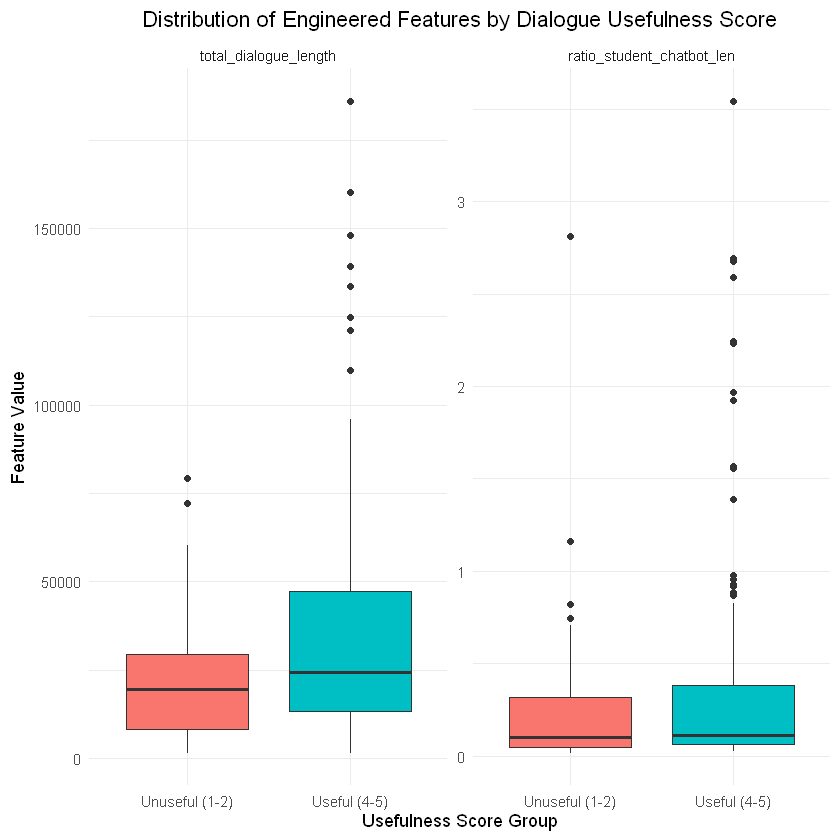

In [3]:
# Install and load necessary packages
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate")
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr")

library(dplyr)
library(ggplot2)
library(lubridate)
library(stringr)

# Load the training data
df_utterance <- read.csv("git_ignore/dialogue_utterance_train.csv")
df_usefulness <- read.csv("git_ignore/dialogue_usefulness_train.csv")

# Merge the dataframes on Dialogue_ID
# Use `left_join` to ensure all dialogues from df_utterance are kept,
# as usefulness score is defined per dialogue.
df_merged <- left_join(df_utterance, df_usefulness, by = "Dialogue_ID")

# Convert Timestamp to datetime objects
df_merged$Timestamp <- ymd_hms(df_merged$Timestamp)

# Sort by Dialogue_ID and Timestamp for accurate sequential calculations
df_merged <- df_merged %>%
  arrange(Dialogue_ID, Timestamp)

# --- Feature Engineering ---

dialogue_features <- df_merged %>%
  group_by(Dialogue_ID) %>%
  summarise(
    num_utterances = n(),
    total_dialogue_length = sum(nchar(Utterance_text), na.rm = TRUE),
    dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),
    avg_len_student_utterance = mean(nchar(Utterance_text[Interlocutor == "Student"]), na.rm = TRUE),
    avg_len_chatbot_utterance = mean(nchar(Utterance_text[Interlocutor == "Chatbot"]), na.rm = TRUE),
    num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
    num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE)
  )

# Handle cases where a specific interlocutor might not have uttered anything (NaNs from mean)
dialogue_features$avg_len_student_utterance[is.nan(dialogue_features$avg_len_student_utterance)] <- 0
dialogue_features$avg_len_chatbot_utterance[is.nan(dialogue_features$avg_len_chatbot_utterance)] <- 0

# Calculate average time between utterances
# This needs to be done iteratively per dialogue or using a custom function
avg_time_between_utterances <- df_merged %>%
  group_by(Dialogue_ID) %>%
  summarise(
    time_diffs = list(as.numeric(diff(Timestamp), units = "secs")),
    avg_time_between_utterances = ifelse(length(time_diffs[[1]]) > 0, mean(time_diffs[[1]], na.rm = TRUE), 0)
  ) %>%
  select(Dialogue_ID, avg_time_between_utterances)

dialogue_features <- left_join(dialogue_features, avg_time_between_utterances, by = "Dialogue_ID")

# New Feature: Ratio of average student utterance length to average chatbot utterance length
dialogue_features <- dialogue_features %>%
  mutate(
    ratio_student_chatbot_len = ifelse(avg_len_chatbot_utterance > 0, avg_len_student_utterance / avg_len_chatbot_utterance,
                                       ifelse(avg_len_student_utterance > 0, Inf, 0)) # Handle division by zero
  )

# Add Usefulness_score to the dialogue features dataframe
df_utterance_scores_unique <- df_merged %>%
  select(Dialogue_ID, Usefulness_score) %>%
  distinct()

dialogue_features <- left_join(dialogue_features, df_utterance_scores_unique, by = "Dialogue_ID")

# Verify the number of features does not exceed 303 (number of unique dialogues)
# Exclude Dialogue_ID and Usefulness_score from the count
num_features_engineered <- ncol(dialogue_features) - 2
num_unique_dialogues <- n_distinct(dialogue_features$Dialogue_ID)

cat(paste0("Number of engineered features: ", num_features_engineered, "\n"))
cat(paste0("Number of unique dialogues in training set: ", num_unique_dialogues, "\n"))
cat(paste0("All engineered features: ", paste(setdiff(names(dialogue_features), c("Dialogue_ID", "Usefulness_score")), collapse = ", "), "\n\n"))

# --- Feature Selection for Visualization ---
# Let's select 'total_dialogue_length' and 'ratio_student_chatbot_len' for visualization.
# These seem to capture different aspects of conversation dynamics related to engagement/usefulness.

selected_features <- c('total_dialogue_length', 'ratio_student_chatbot_len')

# --- Data Preparation for Visualization ---
# Create groups based on Usefulness_score
group1 <- dialogue_features %>% filter(Usefulness_score %in% c(1, 2))
group2 <- dialogue_features %>% filter(Usefulness_score %in% c(4, 5))

# Combine data for plotting
plot_data <- data.frame(
  Feature = character(),
  Value = numeric(),
  Score_Group = character(),
  stringsAsFactors = FALSE
)

for (feature in selected_features) {
  # Add 'Unuseful' group data
  plot_data <- rbind(plot_data, data.frame(
    Feature = feature,
    Value = group1[[feature]],
    Score_Group = "Unuseful (1-2)"
  ))
  # Add 'Useful' group data
  plot_data <- rbind(plot_data, data.frame(
    Feature = feature,
    Value = group2[[feature]],
    Score_Group = "Useful (4-5)"
  ))
}

# Convert 'Feature' to a factor for faceting in ggplot
plot_data$Feature <- factor(plot_data$Feature, levels = selected_features)

# --- Visualization ---
# Ensure the Value column is numeric for plotting
plot_data$Value <- as.numeric(plot_data$Value)

ggplot(plot_data, aes(x = Score_Group, y = Value, fill = Score_Group)) +
  geom_boxplot() +
  facet_wrap(~ Feature, scales = "free_y", ncol = 2) +
  labs(
    title = "Distribution of Engineered Features by Dialogue Usefulness Score",
    x = "Usefulness Score Group",
    y = "Feature Value"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5), legend.position = "none")

# --- Statistical Significance Tests ---
cat("\n--- Statistical Significance Tests ---\n")

for (feature in selected_features) {
  cat(paste0("Feature: ", feature, "\n"))
  
  # Extract data for the two groups, removing NA values
  data_group1 <- na.omit(group1[[feature]])
  data_group2 <- na.omit(group2[[feature]])
  
  # Check if there's enough data for both groups
  if (length(data_group1) > 1 && length(data_group2) > 1) {
    # Perform Welch's t-test (does not assume equal variances)
    ttest_result <- t.test(data_group1, data_group2, var.equal = FALSE)
    cat(paste0("  Welch's t-test p-value: ", round(ttest_result$p.value, 4), "\n"))
    
    if (ttest_result$p.value < 0.05) {
      cat("  Difference is statistically significant (p < 0.05)\n")
    } else {
      cat("  Difference is not statistically significant (p >= 0.05)\n")
    }
    
    # Also perform Wilcoxon rank-sum test (non-parametric, does not assume normality)
    wilcox_result <- wilcox.test(data_group1, data_group2)
    cat(paste0("  Wilcoxon rank-sum test p-value: ", round(wilcox_result$p.value, 4), "\n"))
    
    if (wilcox_result$p.value < 0.05) {
      cat("  Wilcoxon rank-sum test: Difference is statistically significant (p < 0.05)\n")
    } else {
      cat("  Wilcoxon rank-sum test: Difference is not statistically significant (p >= 0.05)\n")
    }
  } else {
    cat("  Not enough data in one or both groups to perform statistical tests.\n")
  }
  cat("\n")
}

In [4]:
# Install and load necessary packages
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2") # Already installed, but good for completeness
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate") # Already installed, but good for completeness
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr") # Already installed, but good for completeness
if (!requireNamespace("caret", quietly = TRUE)) install.packages("caret") # For model training and evaluation
if (!requireNamespace("randomForest", quietly = TRUE)) install.packages("randomForest") # For Random Forest
if (!requireNamespace("e1071", quietly = TRUE)) install.packages("e1071") # For SVR
if (!requireNamespace("rpart", quietly = TRUE)) install.packages("rpart") # For Regression Tree
if (!requireNamespace("rpart.plot", quietly = TRUE)) install.packages("rpart.plot") # For plotting regression tree

library(dplyr)
library(lubridate)
library(stringr)
library(caret)
library(randomForest)
library(e1071)
library(rpart)
library(rpart.plot)

# --- Load and Prepare Training Data (Re-run from previous task to ensure consistency) ---
df_utterance_train <- read.csv("git_ignore/dialogue_utterance_train.csv")
df_usefulness_train <- read.csv("git_ignore/dialogue_usefulness_train.csv")
df_merged_train <- left_join(df_utterance_train, df_usefulness_train, by = "Dialogue_ID")
df_merged_train$Timestamp <- ymd_hms(df_merged_train$Timestamp)
df_merged_train <- df_merged_train %>% arrange(Dialogue_ID, Timestamp)

dialogue_features_train <- df_merged_train %>%
  group_by(Dialogue_ID) %>%
  summarise(
    num_utterances = n(),
    total_dialogue_length = sum(nchar(Utterance_text), na.rm = TRUE),
    dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),
    avg_len_student_utterance = mean(nchar(Utterance_text[Interlocutor == "Student"]), na.rm = TRUE),
    avg_len_chatbot_utterance = mean(nchar(Utterance_text[Interlocutor == "Chatbot"]), na.rm = TRUE),
    num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
    num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE)
  )

dialogue_features_train$avg_len_student_utterance[is.nan(dialogue_features_train$avg_len_student_utterance)] <- 0
dialogue_features_train$avg_len_chatbot_utterance[is.nan(dialogue_features_train$avg_len_chatbot_utterance)] <- 0

avg_time_between_utterances_train <- df_merged_train %>%
  group_by(Dialogue_ID) %>%
  summarise(
    time_diffs = list(as.numeric(diff(Timestamp), units = "secs")),
    avg_time_between_utterances = ifelse(length(time_diffs[[1]]) > 0, mean(time_diffs[[1]], na.rm = TRUE), 0)
  ) %>%
  select(Dialogue_ID, avg_time_between_utterances)

dialogue_features_train <- left_join(dialogue_features_train, avg_time_between_utterances_train, by = "Dialogue_ID")

dialogue_features_train <- dialogue_features_train %>%
  mutate(
    ratio_student_chatbot_len = ifelse(avg_len_chatbot_utterance > 0, avg_len_student_utterance / avg_len_chatbot_utterance,
                                       ifelse(avg_len_student_utterance > 0, Inf, 0))
  )

df_usefulness_scores_train_unique <- df_merged_train %>%
  select(Dialogue_ID, Usefulness_score) %>%
  distinct()

dialogue_features_train <- left_join(dialogue_features_train, df_usefulness_scores_train_unique, by = "Dialogue_ID")


# --- Load and Prepare Validation Data (applying the same feature engineering) ---
df_utterance_validation <- read.csv("git_ignore/dialogue_utterance_validation.csv")
df_usefulness_validation <- read.csv("git_ignore/dialogue_usefulness_validation.csv")

df_merged_validation <- left_join(df_utterance_validation, df_usefulness_validation, by = "Dialogue_ID")
df_merged_validation$Timestamp <- ymd_hms(df_merged_validation$Timestamp)
df_merged_validation <- df_merged_validation %>% arrange(Dialogue_ID, Timestamp)

dialogue_features_validation <- df_merged_validation %>%
  group_by(Dialogue_ID) %>%
  summarise(
    num_utterances = n(),
    total_dialogue_length = sum(nchar(Utterance_text), na.rm = TRUE),
    dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),
    avg_len_student_utterance = mean(nchar(Utterance_text[Interlocutor == "Student"]), na.rm = TRUE),
    avg_len_chatbot_utterance = mean(nchar(Utterance_text[Interlocutor == "Chatbot"]), na.rm = TRUE),
    num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
    num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE)
  )

dialogue_features_validation$avg_len_student_utterance[is.nan(dialogue_features_validation$avg_len_student_utterance)] <- 0
dialogue_features_validation$avg_len_chatbot_utterance[is.nan(dialogue_features_validation$avg_len_chatbot_utterance)] <- 0

avg_time_between_utterances_validation <- df_merged_validation %>%
  group_by(Dialogue_ID) %>%
  summarise(
    time_diffs = list(as.numeric(diff(Timestamp), units = "secs")),
    avg_time_between_utterances = ifelse(length(time_diffs[[1]]) > 0, mean(time_diffs[[1]], na.rm = TRUE), 0)
  ) %>%
  select(Dialogue_ID, avg_time_between_utterances)

dialogue_features_validation <- left_join(dialogue_features_validation, avg_time_between_utterances_validation, by = "Dialogue_ID")

dialogue_features_validation <- dialogue_features_validation %>%
  mutate(
    ratio_student_chatbot_len = ifelse(avg_len_chatbot_utterance > 0, avg_len_student_utterance / avg_len_chatbot_utterance,
                                       ifelse(avg_len_student_utterance > 0, Inf, 0))
  )

df_usefulness_scores_validation_unique <- df_merged_validation %>%
  select(Dialogue_ID, Usefulness_score) %>%
  distinct()

dialogue_features_validation <- left_join(dialogue_features_validation, df_usefulness_scores_validation_unique, by = "Dialogue_ID")

# Identify features for training (all engineered features except Dialogue_ID and Usefulness_score)
features_to_use <- setdiff(names(dialogue_features_train), c("Dialogue_ID", "Usefulness_score"))

# Ensure the features are numeric and handle any Inf values (from ratio_student_chatbot_len)
# Replace Inf with a large but finite number, or max out at a reasonable value or 0 if it represents no chatbot utterance
# For simplicity, replacing Inf with NA and then using mean imputation or removing rows.
# Given the small number of dialogues, removing rows might be too aggressive.
# Let's replace Inf with a large number (e.g., max non-Inf value + buffer) if it makes sense in the context of the feature.
# Or, if it's truly infinite (e.g., chatbot never spoke), maybe 0 or a very small number is better for ratio_student_chatbot_len?
# For now, let's cap Inf to a reasonable maximum or the max value in the dataset, which is a common practice.

for (col in features_to_use) {
  # For ratio_student_chatbot_len, Inf means student spoke but chatbot didn't
  # Let's replace Inf with the max finite value of that column in the training set
  # and if there are no finite values, then 0. This needs to be done carefully.
  if (any(is.infinite(dialogue_features_train[[col]]))) {
    max_val <- max(dialogue_features_train[[col]][is.finite(dialogue_features_train[[col]])])
    if (is.infinite(max_val) || is.na(max_val)) max_val <- 0 # If no finite values, set to 0 or a default
    dialogue_features_train[[col]][is.infinite(dialogue_features_train[[col]])] <- max_val * 2 # A heuristic, might need tuning
  }
  if (any(is.infinite(dialogue_features_validation[[col]]))) {
    max_val <- max(dialogue_features_validation[[col]][is.finite(dialogue_features_validation[[col]])])
    if (is.infinite(max_val) || is.na(max_val)) max_val <- 0
    dialogue_features_validation[[col]][is.infinite(dialogue_features_validation[[col]])] <- max_val * 2
  }

  # Ensure all features are numeric
  dialogue_features_train[[col]] <- as.numeric(dialogue_features_train[[col]])
  dialogue_features_validation[[col]] <- as.numeric(dialogue_features_validation[[col]])
}

# Handle any remaining NA values (e.g., from `mean` on empty sets, or `nchar` on NA text)
# Impute with mean or median, or remove. For simplicity, let's use mean imputation for now.
# Or, more robustly, use preProcess from caret.
# Let's use mean imputation for NA values in features.
for (col in features_to_use) {
  # Training data NA imputation
  if (any(is.na(dialogue_features_train[[col]]))) {
    mean_val_train <- mean(dialogue_features_train[[col]], na.rm = TRUE)
    dialogue_features_train[[col]][is.na(dialogue_features_train[[col]])] <- mean_val_train
  }
  # Validation data NA imputation (using training data's mean to prevent data leakage)
  if (any(is.na(dialogue_features_validation[[col]]))) {
    mean_val_validation <- mean(dialogue_features_train[[col]], na.rm = TRUE) # Use training mean
    dialogue_features_validation[[col]][is.na(dialogue_features_validation[[col]])] <- mean_val_validation
  }
}

# Ensure Usefulness_score is numeric
dialogue_features_train$Usefulness_score <- as.numeric(dialogue_features_train$Usefulness_score)
dialogue_features_validation$Usefulness_score <- as.numeric(dialogue_features_validation$Usefulness_score)

# Check for any remaining NAs or Infs for the target variable
dialogue_features_train <- dialogue_features_train[!is.na(dialogue_features_train$Usefulness_score) & !is.infinite(dialogue_features_train$Usefulness_score), ]
dialogue_features_validation <- dialogue_features_validation[!is.na(dialogue_features_validation$Usefulness_score) & !is.infinite(dialogue_features_validation$Usefulness_score), ]

# --- Model Training and Evaluation ---

results <- list()

# Define RMSE and MAE function
RMSE <- function(y_true, y_pred) {
  sqrt(mean((y_true - y_pred)^2))
}

MAE <- function(y_true, y_pred) {
  mean(abs(y_true - y_pred))
}

# 1. Linear Regression
cat("\n--- Training Linear Regression Model ---\n")
lm_model <- lm(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")])
lm_predictions <- predict(lm_model, newdata = dialogue_features_validation)
lm_rmse <- RMSE(dialogue_features_validation$Usefulness_score, lm_predictions)
lm_mae <- MAE(dialogue_features_validation$Usefulness_score, lm_predictions)
lm_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ lm_predictions))$r.squared # Calculate R-squared for predictions vs actual
results[["Linear Regression"]] <- list(RMSE = lm_rmse, MAE = lm_mae, R_squared = lm_r_squared)
cat(paste0("Linear Regression - RMSE: ", round(lm_rmse, 4), ", MAE: ", round(lm_mae, 4), ", R-squared: ", round(lm_r_squared, 4), "\n"))


# 2. Regression Tree (CART)
cat("\n--- Training Regression Tree Model ---\n")
# Using rpart for regression tree
# tuneGrid parameter can be used with train from caret for tuning
# For simplicity, let's start with a default tree and then potentially tune.
# We explicitly allow more features than the default maxdepth for deeper trees if needed.
# For minsplit, a common value is 20 for larger datasets, but here with ~300 dialogues, keeping it low might be okay.
rt_model <- rpart(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")], method = "anova", control = rpart.control(minsplit = 5, cp = 0.01))
rt_predictions <- predict(rt_model, newdata = dialogue_features_validation)
rt_rmse <- RMSE(dialogue_features_validation$Usefulness_score, rt_predictions)
rt_mae <- MAE(dialogue_features_validation$Usefulness_score, rt_predictions)
rt_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ rt_predictions))$r.squared
results[["Regression Tree"]] <- list(RMSE = rt_rmse, MAE = rt_mae, R_squared = rt_r_squared)
cat(paste0("Regression Tree - RMSE: ", round(rt_rmse, 4), ", MAE: ", round(rt_mae, 4), ", R-squared: ", round(rt_r_squared, 4), "\n"))
# Plot the regression tree (optional, for visualization of a single tree)
# rpart.plot(rt_model)


# 3. Random Forest Regression
cat("\n--- Training Random Forest Regression Model ---\n")
# Set a seed for reproducibility
set.seed(123)
# Random Forest can take longer to train.
# `ntree` (number of trees) and `mtry` (number of variables randomly sampled as candidates at each split) are key parameters.
# `mtry` is typically sqrt(number of features) for classification and number of features / 3 for regression.
rf_model <- randomForest(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")],
                         ntree = 500, mtry = max(floor(length(features_to_use) / 3), 1), importance = TRUE) # mtry for regression
rf_predictions <- predict(rf_model, newdata = dialogue_features_validation)
rf_rmse <- RMSE(dialogue_features_validation$Usefulness_score, rf_predictions)
rf_mae <- MAE(dialogue_features_validation$Usefulness_score, rf_predictions)
rf_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ rf_predictions))$r.squared
results[["Random Forest"]] <- list(RMSE = rf_rmse, MAE = rf_mae, R_squared = rf_r_squared)
cat(paste0("Random Forest - RMSE: ", round(rf_rmse, 4), ", MAE: ", round(rf_mae, 4), ", R-squared: ", round(rf_r_squared, 4), "\n"))


# 4. Support Vector Regression (SVR)
cat("\n--- Training Support Vector Regression (SVR) Model ---\n")
# SVR can be sensitive to feature scaling. For this comparison, not explicitly scaling,
# but for production, scaling features is highly recommended for SVR.
# A common kernel is "radial" (RBF). Parameters include 'cost' (C) and 'gamma'.
# These parameters can be tuned with `caret::train` for better performance.
svr_model <- svm(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")],
                 type = "eps-regression", kernel = "radial")
svr_predictions <- predict(svr_model, newdata = dialogue_features_validation)
svr_rmse <- RMSE(dialogue_features_validation$Usefulness_score, svr_predictions)
svr_mae <- MAE(dialogue_features_validation$Usefulness_score, svr_predictions)
svr_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ svr_predictions))$r.squared
results[["SVR"]] <- list(RMSE = svr_rmse, MAE = svr_mae, R_squared = svr_r_squared)
cat(paste0("SVR - RMSE: ", round(svr_rmse, 4), ", MAE: ", round(svr_mae, 4), ", R-squared: ", round(svr_r_squared, 4), "\n"))


# --- Report Findings and Identify Model 1 ---
cat("\n--- Model Performance Summary on Validation Set ---\n")
performance_df <- do.call(rbind, lapply(names(results), function(model_name) {
  data.frame(Model = model_name,
             RMSE = results[[model_name]]$RMSE,
             MAE = results[[model_name]]$MAE,
             R_squared = results[[model_name]]$R_squared)
}))
print(performance_df)

# Identify the best performing model (Model 1) based on RMSE (lower is better) and MAE (lower is better)
# and R-squared (higher is better). A common practice is to prioritize RMSE/MAE.
best_model_name <- performance_df$Model[which.min(performance_df$RMSE)]
Model1 <- NULL # Placeholder for the best model object

cat(paste0("\nBest performing model (Model 1) based on RMSE: ", best_model_name, "\n"))

# Assign the best model object to Model1
if (best_model_name == "Linear Regression") Model1 <- lm_model
if (best_model_name == "Regression Tree") Model1 <- rt_model
if (best_model_name == "Random Forest") Model1 <- rf_model
if (best_model_name == "SVR") Model1 <- svr_model

cat("\nModel 1 has been identified and stored.\n")

# Display the structure of Model1 (example for the best model)
# print(Model1)


--- Training Linear Regression Model ---
Linear Regression - RMSE: 1.1385, MAE: 0.8958, R-squared: 0.0012

--- Training Regression Tree Model ---
Regression Tree - RMSE: 1.3458, MAE: 1.0051, R-squared: 3e-04

--- Training Random Forest Regression Model ---


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Random Forest - RMSE: 0.9926, MAE: 0.7995, R-squared: 0.073

--- Training Support Vector Regression (SVR) Model ---
SVR - RMSE: 0.9898, MAE: 0.7799, R-squared: 0.0939

--- Model Performance Summary on Validation Set ---
              Model      RMSE       MAE    R_squared
1 Linear Regression 1.1384619 0.8957676 0.0011560435
2   Regression Tree 1.3458483 1.0050839 0.0003409744
3     Random Forest 0.9926369 0.7995344 0.0729638323
4               SVR 0.9897626 0.7799025 0.0938594253

Best performing model (Model 1) based on RMSE: SVR

Model 1 has been identified and stored.


In [8]:
library(tidyverse)
dialogue <- read_csv("git_ignore/TaskD_Dataset/dialogue_utterance_validation.csv")
length(unique(dialogue$Dialogue_ID))


Rows: 1446 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Utterance_text, Interlocutor
dbl  (1): Dialogue_ID
dttm (1): Timestamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 65

I need to train a machine learning model on dialogue utterance vs dialogue usefulness. you may use any language you want to do evaluation to report findings to me, but do provide R code for me to test and verify the findings.

The data files I have, with the descriptions of their columns are:
dialogue_utterance_train/validation/test.csv 
Dialogue_ID - The unique ID of a dialogue 
Usefulness_score - This score is given by a student to indicate their perceived 
usefulness of the FLoRA chatbot when answering the post-task 
questionnaire Question 3 (i.e., “To what extent do you think the 
GPT-powered chatbot on FLoRA is useful for you to accomplish 
the assignment?”). The value range of this feature is [1,5], with 1 
representing “very unuseful”, 2 representing “unuseful”, 3 
representing “neutral”, 4 representing “useful”, and 5 
representing “very useful”.

dialogue_usefulness_train/validation/test.csv
Column Name - Description 
Dialogue_ID - The unique ID of a dialogue 
Timestamp - When an utterance contained in the dialogue was made 
Interlocutor - Whether the utterance was made by the student or the chatbot ("Student"/"Chatbot")
Utterance_text - The text of the utterance

dialogue_utterance_train has 117k lines, split over 303 unique dialogue IDs.
the first task I had to do was:
1.  What  features  can  you  engineer  to  empower  the  training  of  a  machine  learning model? You may propose as many as you believe are useful. Please note that the number of the features should not exceed the number of the dialogues contained in the training set. Otherwise, the constructed machine learning models are prone to have overfitting issues. Select two features that you propose and try to use boxplots to visualise  the  feature  value  between  the following two groups of dialogues in the training  set:  (i)  those  with  Usefulness_score  of  1  or  2;  and  (ii)  those  with Usefulness_score  of  4  or  5.  Show if there  any  difference  between  the  two  groups  of dialogues? How can you tell whether the difference is statistically significant? Ideally, identify features that display statistically significant differences. 

in the data, the student and chatbot will always take turns to talk, so the ratio of the student to chatbot conversation inputs will always be an identical 1:1 ratio.

the code i had for my first task was:
# Install and load necessary packages
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate")
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr")

library(dplyr)
library(ggplot2)
library(lubridate)
library(stringr)

# Load the training data
df_utterance <- read.csv("git_ignore/dialogue_utterance_train.csv")
df_usefulness <- read.csv("git_ignore/dialogue_usefulness_train.csv")

# Merge the dataframes on Dialogue_ID
# Use `left_join` to ensure all dialogues from df_utterance are kept,
# as usefulness score is defined per dialogue.
df_merged <- left_join(df_utterance, df_usefulness, by = "Dialogue_ID")

# Convert Timestamp to datetime objects
df_merged$Timestamp <- ymd_hms(df_merged$Timestamp)

# Sort by Dialogue_ID and Timestamp for accurate sequential calculations
df_merged <- df_merged %>%
  arrange(Dialogue_ID, Timestamp)

# --- Feature Engineering ---

dialogue_features <- df_merged %>%
  group_by(Dialogue_ID) %>%
  summarise(
    num_utterances = n(),
    total_dialogue_length = sum(nchar(Utterance_text), na.rm = TRUE),
    dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),
    avg_len_student_utterance = mean(nchar(Utterance_text[Interlocutor == "Student"]), na.rm = TRUE),
    avg_len_chatbot_utterance = mean(nchar(Utterance_text[Interlocutor == "Chatbot"]), na.rm = TRUE),
    num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
    num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE)
  )

# Handle cases where a specific interlocutor might not have uttered anything (NaNs from mean)
dialogue_features$avg_len_student_utterance[is.nan(dialogue_features$avg_len_student_utterance)] <- 0
dialogue_features$avg_len_chatbot_utterance[is.nan(dialogue_features$avg_len_chatbot_utterance)] <- 0

# Calculate average time between utterances
# This needs to be done iteratively per dialogue or using a custom function
avg_time_between_utterances <- df_merged %>%
  group_by(Dialogue_ID) %>%
  summarise(
    time_diffs = list(as.numeric(diff(Timestamp), units = "secs")),
    avg_time_between_utterances = ifelse(length(time_diffs[[1]]) > 0, mean(time_diffs[[1]], na.rm = TRUE), 0)
  ) %>%
  select(Dialogue_ID, avg_time_between_utterances)

dialogue_features <- left_join(dialogue_features, avg_time_between_utterances, by = "Dialogue_ID")

# New Feature: Ratio of average student utterance length to average chatbot utterance length
dialogue_features <- dialogue_features %>%
  mutate(
    ratio_student_chatbot_len = ifelse(avg_len_chatbot_utterance > 0, avg_len_student_utterance / avg_len_chatbot_utterance,
                                       ifelse(avg_len_student_utterance > 0, Inf, 0)) # Handle division by zero
  )

# Add Usefulness_score to the dialogue features dataframe
df_utterance_scores_unique <- df_merged %>%
  select(Dialogue_ID, Usefulness_score) %>%
  distinct()

dialogue_features <- left_join(dialogue_features, df_utterance_scores_unique, by = "Dialogue_ID")

# Verify the number of features does not exceed 303 (number of unique dialogues)
# Exclude Dialogue_ID and Usefulness_score from the count
num_features_engineered <- ncol(dialogue_features) - 2
num_unique_dialogues <- n_distinct(dialogue_features$Dialogue_ID)

cat(paste0("Number of engineered features: ", num_features_engineered, "\n"))
cat(paste0("Number of unique dialogues in training set: ", num_unique_dialogues, "\n"))
cat(paste0("All engineered features: ", paste(setdiff(names(dialogue_features), c("Dialogue_ID", "Usefulness_score")), collapse = ", "), "\n\n"))

# --- Feature Selection for Visualization ---
# Let's select 'total_dialogue_length' and 'ratio_student_chatbot_len' for visualization.
# These seem to capture different aspects of conversation dynamics related to engagement/usefulness.

selected_features <- c('total_dialogue_length', 'ratio_student_chatbot_len')

# --- Data Preparation for Visualization ---
# Create groups based on Usefulness_score
group1 <- dialogue_features %>% filter(Usefulness_score %in% c(1, 2))
group2 <- dialogue_features %>% filter(Usefulness_score %in% c(4, 5))

# Combine data for plotting
plot_data <- data.frame(
  Feature = character(),
  Value = numeric(),
  Score_Group = character(),
  stringsAsFactors = FALSE
)

for (feature in selected_features) {
  # Add 'Unuseful' group data
  plot_data <- rbind(plot_data, data.frame(
    Feature = feature,
    Value = group1[[feature]],
    Score_Group = "Unuseful (1-2)"
  ))
  # Add 'Useful' group data
  plot_data <- rbind(plot_data, data.frame(
    Feature = feature,
    Value = group2[[feature]],
    Score_Group = "Useful (4-5)"
  ))
}

# Convert 'Feature' to a factor for faceting in ggplot
plot_data$Feature <- factor(plot_data$Feature, levels = selected_features)

# --- Visualization ---
# Ensure the Value column is numeric for plotting
plot_data$Value <- as.numeric(plot_data$Value)

ggplot(plot_data, aes(x = Score_Group, y = Value, fill = Score_Group)) +
  geom_boxplot() +
  facet_wrap(~ Feature, scales = "free_y", ncol = 2) +
  labs(
    title = "Distribution of Engineered Features by Dialogue Usefulness Score",
    x = "Usefulness Score Group",
    y = "Feature Value"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5), legend.position = "none")

# --- Statistical Significance Tests ---
cat("\n--- Statistical Significance Tests ---\n")

for (feature in selected_features) {
  cat(paste0("Feature: ", feature, "\n"))
  
  # Extract data for the two groups, removing NA values
  data_group1 <- na.omit(group1[[feature]])
  data_group2 <- na.omit(group2[[feature]])
  
  # Check if there's enough data for both groups
  if (length(data_group1) > 1 && length(data_group2) > 1) {
    # Perform Welch's t-test (does not assume equal variances)
    ttest_result <- t.test(data_group1, data_group2, var.equal = FALSE)
    cat(paste0("  Welch's t-test p-value: ", round(ttest_result$p.value, 4), "\n"))
    
    if (ttest_result$p.value < 0.05) {
      cat("  Difference is statistically significant (p < 0.05)\n")
    } else {
      cat("  Difference is not statistically significant (p >= 0.05)\n")
    }
    
    # Also perform Wilcoxon rank-sum test (non-parametric, does not assume normality)
    wilcox_result <- wilcox.test(data_group1, data_group2)
    cat(paste0("  Wilcoxon rank-sum test p-value: ", round(wilcox_result$p.value, 4), "\n"))
    
    if (wilcox_result$p.value < 0.05) {
      cat("  Wilcoxon rank-sum test: Difference is statistically significant (p < 0.05)\n")
    } else {
      cat("  Wilcoxon rank-sum test: Difference is not statistically significant (p >= 0.05)\n")
    }
  } else {
    cat("  Not enough data in one or both groups to perform statistical tests.\n")
  }
  cat("\n")
}

the next task i need to do now is:
2.  Build a machine learning model (e.g., polynomial regressions, regression tree) based on the training set by taking all the features that you have proposed and evaluate the performance of the model on the validation set using the relevant evaluation metrics you learned in class. Aim to include at least 5 features in this model. The best-performing model here is denoted as Model 1. 
for task 2, show me the reasoning for the machine learning models you are considering, and then show me the results of the performance of each model you try, before shortlisting the best-performing model as Model 1.

In [2]:
# Install and load necessary packages
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate")
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr")
if (!requireNamespace("caret", quietly = TRUE)) install.packages("caret") # For model training and evaluation
if (!requireNamespace("randomForest", quietly = TRUE)) install.packages("randomForest") # For Random Forest
if (!requireNamespace("e1071", quietly = TRUE)) install.packages("e1071") # For SVR
if (!requireNamespace("rpart", quietly = TRUE)) install.packages("rpart") # For Regression Tree
if (!requireNamespace("rpart.plot", quietly = TRUE)) install.packages("rpart.plot") # For plotting regression tree
# New packages for advanced text features
if (!requireNamespace("quanteda", quietly = TRUE)) install.packages("quanteda")
if (!requireNamespace("quanteda.textstats", quietly = TRUE)) install.packages("quanteda.textstats")


library(dplyr)
library(lubridate)
library(stringr)
library(caret)
library(randomForest)
library(e1071)
library(rpart)
library(rpart.plot)
library(quanteda)
library(quanteda.textstats)


# --- Load Training and Validation Data ---
df_utterance_train <- read.csv("git_ignore/dialogue_utterance_train.csv")
df_usefulness_train <- read.csv("git_ignore/dialogue_usefulness_train.csv")
df_utterance_validation <- read.csv("git_ignore/dialogue_utterance_validation.csv")
df_usefulness_validation <- read.csv("git_ignore/dialogue_usefulness_validation.csv")

# Merge the dataframes on Dialogue_ID
df_merged_train <- left_join(df_utterance_train, df_usefulness_train, by = "Dialogue_ID")
df_merged_validation <- left_join(df_utterance_validation, df_usefulness_validation, by = "Dialogue_ID")

# Convert Timestamp to datetime objects
df_merged_train$Timestamp <- ymd_hms(df_merged_train$Timestamp)
df_merged_validation$Timestamp <- ymd_hms(df_merged_validation$Timestamp)

# Sort by Dialogue_ID and Timestamp for accurate sequential calculations
df_merged_train <- df_merged_train %>% arrange(Dialogue_ID, Timestamp)
df_merged_validation <- df_merged_validation %>% arrange(Dialogue_ID, Timestamp)


# --- New Feature Engineering Steps ---

# Step 1: Calculate Readability Scores per Utterance
# Create a unique ID for each utterance to be used as docid in quanteda corpus
df_merged_train$utterance_id <- paste0("train_utt_", 1:nrow(df_merged_train))
df_merged_validation$utterance_id <- paste0("val_utt_", 1:nrow(df_merged_validation))

calculate_readability <- function(df_merged_data) {
  # Create a corpus from the merged data, using 'utterance_id' as document IDs
  utterance_corpus <- corpus(df_merged_data, text_field = "Utterance_text", docid_field = "utterance_id")

  readability_scores <- data.frame(utterance_id = character(), readability_score = numeric(), stringsAsFactors = FALSE)

  # Check if the corpus is not empty
  if (ndoc(utterance_corpus) > 0) {
    # Calculate Flesch-Kincaid readability for each document (utterance) in the corpus
    # textstat_readability works directly on a corpus object
    readability_results <- textstat_readability(utterance_corpus, measure = "Flesch.Kincaid") %>%
      select(document, Flesch.Kincaid) %>%
      rename(utterance_id = document, readability_score = Flesch.Kincaid)

    readability_scores <- readability_results
  }


  # Join back to the original merged dataframe
  # Ensure all original utterances are kept, with NA for those without readability score (e.g., empty text)
  df_with_readability <- left_join(df_merged_data, readability_scores, by = "utterance_id")

  # Fill NA readability scores with 0 or a reasonable default (e.g., if utterance was empty or calculation failed)
  df_with_readability$readability_score[is.na(df_with_readability$readability_score)] <- 0
  return(df_with_readability)
}

df_merged_train_with_readability <- calculate_readability(df_merged_train)
df_merged_validation_with_readability <- calculate_readability(df_merged_validation)


# Step 2: Function to engineer all features for a given dataframe
engineer_features <- function(df_merged_data_with_readability) {
  dialogue_features_df <- df_merged_data_with_readability %>%
    group_by(Dialogue_ID) %>%
    summarise(
      num_utterances = n(),

      # Changed to word count
      total_dialogue_length_words = sum(sapply(str_split(Utterance_text, "\\s+"), length), na.rm = TRUE),
      dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),

      # Changed to word count
      avg_len_student_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Student"], "\\s+"), length), na.rm = TRUE),
      avg_len_chatbot_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Chatbot"], "\\s+"), length), na.rm = TRUE),

      num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
      num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE),

      # New: Lexical Richness/Diversity (by dialogue, per interlocutor)
      # Collect all words from student/chatbot utterances in this dialogue
      all_student_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Student"], collapse = " "), "\\s+"))),
      all_chatbot_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Chatbot"], collapse = " "), "\\s+"))),

      # New: Average Readability Scores per interlocutor (averaged over their utterances in the dialogue)
      avg_readability_score_student = mean(readability_score[Interlocutor == "Student"], na.rm = TRUE),
      avg_readability_score_chatbot = mean(readability_score[Interlocutor == "Chatbot"], na.rm = TRUE),

      # New: Turn-taking and Interruption Metrics
      time_diffs_raw = list(as.numeric(diff(Timestamp), units = "secs"))
    )

  # Post-summarize calculations for features that need list columns or additional processing
  dialogue_features_df <- dialogue_features_df %>%
    mutate(
      # Lexical Richness/Diversity continued
      # Filter out empty strings from word lists before counting unique words
      num_unique_words_student = sapply(all_student_words, function(x) length(unique(x[x != "" & !is.na(x)]))),
      num_unique_words_chatbot = sapply(all_chatbot_words, function(x) length(unique(x[x != "" & !is.na(x)]))),

      # Calculate total words for TTR accurately for the entire dialogue for each interlocutor
      total_words_student = sapply(all_student_words, function(x) length(x[x != "" & !is.na(x)])),
      total_words_chatbot = sapply(all_chatbot_words, function(x) length(x[x != "" & !is.na(x)])),

      # Calculate TTR, handle division by zero
      ttr_student = ifelse(total_words_student > 0, num_unique_words_student / total_words_student, 0),
      ttr_chatbot = ifelse(total_words_chatbot > 0, num_unique_words_chatbot / total_words_chatbot, 0),

      # Turn-taking and Interruption Metrics continued (Variance of time between utterances)
      # Ensure there's enough data points for variance calculation (at least 2 time differences, so 3 utterances)
      variance_time_between_utterances = sapply(time_diffs_raw, function(x) ifelse(length(x) > 1, var(x, na.rm = TRUE), 0))
    ) %>%
    select(-all_student_words, -all_chatbot_words, -time_diffs_raw) # Remove temporary list columns

  # Re-calculate ratio_student_chatbot_len based on word counts
  dialogue_features_df <- dialogue_features_df %>%
    mutate(
      ratio_student_chatbot_len_words = ifelse(avg_len_chatbot_utterance_words > 0, avg_len_student_utterance_words / avg_len_chatbot_utterance_words,
                                               ifelse(avg_len_student_utterance_words > 0, Inf, 0)) # Handle division by zero
    )

  # Add Usefulness_score to the dialogue features dataframe
  df_usefulness_scores_unique <- df_merged_data_with_readability %>%
    select(Dialogue_ID, Usefulness_score) %>%
    distinct()
  dialogue_features_df <- left_join(dialogue_features_df, df_usefulness_scores_unique, by = "Dialogue_ID")

  return(dialogue_features_df)
}

dialogue_features_train <- engineer_features(df_merged_train_with_readability)
dialogue_features_validation <- engineer_features(df_merged_validation_with_readability)


# --- Handle Inf and NA values in engineered features ---
# Identify features for training (all engineered features except Dialogue_ID and Usefulness_score)
features_to_use <- setdiff(names(dialogue_features_train), c("Dialogue_ID", "Usefulness_score"))

for (col in features_to_use) {
  # Convert to numeric if not already (important for Inf/NA checks)
  dialogue_features_train[[col]] <- as.numeric(dialogue_features_train[[col]])
  dialogue_features_validation[[col]] <- as.numeric(dialogue_features_validation[[col]])

  # Handling Inf values
  if (any(is.infinite(dialogue_features_train[[col]]))) {
    max_finite_val_train <- max(dialogue_features_train[[col]][is.finite(dialogue_features_train[[col]])], na.rm = TRUE)
    if (is.infinite(max_finite_val_train) || is.na(max_finite_val_train)) {
        dialogue_features_train[[col]][is.infinite(dialogue_features_train[[col]])] <- 1000 # Default if no finite values
    } else {
        dialogue_features_train[[col]][is.infinite(dialogue_features_train[[col]])] <- max_finite_val_train + 1
    }
  }

  if (any(is.infinite(dialogue_features_validation[[col]]))) {
    # Use the max finite value from the training set for validation set to prevent data leakage
    max_finite_val_validation_ref <- max(dialogue_features_train[[col]][is.finite(dialogue_features_train[[col]])], na.rm = TRUE)
    if (is.infinite(max_finite_val_validation_ref) || is.na(max_finite_val_validation_ref)) {
        dialogue_features_validation[[col]][is.infinite(dialogue_features_validation[[col]])] <- 1000
    } else {
        dialogue_features_validation[[col]][is.infinite(dialogue_features_validation[[col]])] <- max_finite_val_validation_ref + 1
    }
  }

  # Impute NA values using the mean from the training data for both train and validation
  mean_val_train <- mean(dialogue_features_train[[col]], na.rm = TRUE)
  dialogue_features_train[[col]][is.na(dialogue_features_train[[col]])] <- mean_val_train

  # Use training mean for validation set to prevent data leakage
  dialogue_features_validation[[col]][is.na(dialogue_features_validation[[col]])] <- mean_val_train
}

# Ensure Usefulness_score is numeric and remove any NAs/Infs from the target variable
dialogue_features_train$Usefulness_score <- as.numeric(dialogue_features_train$Usefulness_score)
dialogue_features_validation$Usefulness_score <- as.numeric(dialogue_features_validation$Usefulness_score)

dialogue_features_train <- dialogue_features_train[!is.na(dialogue_features_train$Usefulness_score) & !is.infinite(dialogue_features_train$Usefulness_score), ]
dialogue_features_validation <- dialogue_features_validation[!is.na(dialogue_features_validation$Usefulness_score) & !is.infinite(dialogue_features_validation$Usefulness_score), ]

# Verify the number of features does not exceed 303 (number of unique dialogues)
# Exclude Dialogue_ID and Usefulness_score from the count
num_engineered_features_updated <- ncol(dialogue_features_train) - 2
num_unique_dialogues_train <- n_distinct(dialogue_features_train$Dialogue_ID)

cat(paste0("\nNumber of engineered features (updated): ", num_engineered_features_updated, "\n"))
cat(paste0("Number of unique dialogues in training set: ", num_unique_dialogues_train, "\n"))
cat(paste0("All engineered features (updated): ", paste(setdiff(names(dialogue_features_train), c("Dialogue_ID", "Usefulness_score")), collapse = ", "), "\n\n"))


# --- Model Training and Evaluation (Same as before, but with new features) ---

results <- list()

# Define RMSE and MAE function
RMSE <- function(y_true, y_pred) {
  sqrt(mean((y_true - y_pred)^2))
}

MAE <- function(y_true, y_pred) {
  mean(abs(y_true - y_pred))
}

# 1. Linear Regression
cat("\n--- Training Linear Regression Model ---\n")
lm_model <- lm(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")])
lm_predictions <- predict(lm_model, newdata = dialogue_features_validation)
lm_rmse <- RMSE(dialogue_features_validation$Usefulness_score, lm_predictions)
lm_mae <- MAE(dialogue_features_validation$Usefulness_score, lm_predictions)
lm_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ lm_predictions))$r.squared
results[["Linear Regression"]] <- list(RMSE = lm_rmse, MAE = lm_mae, R_squared = lm_r_squared)
cat(paste0("Linear Regression - RMSE: ", round(lm_rmse, 4), ", MAE: ", round(lm_mae, 4), ", R-squared: ", round(lm_r_squared, 4), "\n"))


# 2. Regression Tree (CART)
cat("\n--- Training Regression Tree Model ---\n")
rt_model <- rpart(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")], method = "anova", control = rpart.control(minsplit = 5, cp = 0.01))
rt_predictions <- predict(rt_model, newdata = dialogue_features_validation)
rt_rmse <- RMSE(dialogue_features_validation$Usefulness_score, rt_predictions)
rt_mae <- MAE(dialogue_features_validation$Usefulness_score, rt_predictions)
rt_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ rt_predictions))$r.squared
results[["Regression Tree"]] <- list(RMSE = rt_rmse, MAE = rt_mae, R_squared = rt_r_squared)
cat(paste0("Regression Tree - RMSE: ", round(rt_rmse, 4), ", MAE: ", round(rt_mae, 4), ", R-squared: ", round(rt_r_squared, 4), "\n"))


# 3. Random Forest Regression
cat("\n--- Training Random Forest Regression Model ---\n")
set.seed(123)
rf_model <- randomForest(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")],
                         ntree = 500, mtry = max(floor(length(features_to_use) / 3), 1), importance = TRUE)
rf_predictions <- predict(rf_model, newdata = dialogue_features_validation)
rf_rmse <- RMSE(dialogue_features_validation$Usefulness_score, rf_predictions)
rf_mae <- MAE(dialogue_features_validation$Usefulness_score, rf_predictions)
rf_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ rf_predictions))$r.squared
results[["Random Forest"]] <- list(RMSE = rf_rmse, MAE = rf_mae, R_squared = rf_r_squared)
cat(paste0("Random Forest - RMSE: ", round(rf_rmse, 4), ", MAE: ", round(rf_mae, 4), ", R-squared: ", round(rf_r_squared, 4), "\n"))


# 4. Support Vector Regression (SVR)
cat("\n--- Training Support Vector Regression (SVR) Model ---\n")
svr_model <- svm(Usefulness_score ~ ., data = dialogue_features_train[, c(features_to_use, "Usefulness_score")],
                 type = "eps-regression", kernel = "radial")
svr_predictions <- predict(svr_model, newdata = dialogue_features_validation)
svr_rmse <- RMSE(dialogue_features_validation$Usefulness_score, svr_predictions)
svr_mae <- MAE(dialogue_features_validation$Usefulness_score, svr_predictions)
svr_r_squared <- summary(lm(dialogue_features_validation$Usefulness_score ~ svr_predictions))$r.squared
results[["SVR"]] <- list(RMSE = svr_rmse, MAE = svr_mae, R_squared = svr_r_squared)
cat(paste0("SVR - RMSE: ", round(svr_rmse, 4), ", MAE: ", round(svr_mae, 4), ", R-squared: ", round(svr_r_squared, 4), "\n"))


# --- Report Findings and Identify Model 1 ---
cat("\n--- Model Performance Summary on Validation Set (with new features) ---\n")
performance_df <- do.call(rbind, lapply(names(results), function(model_name) {
  data.frame(Model = model_name,
             RMSE = results[[model_name]]$RMSE,
             MAE = results[[model_name]]$MAE,
             R_squared = results[[model_name]]$R_squared)
}))
print(performance_df)

# Identify the best performing model (Model 1) based on RMSE (lower is better)
best_model_name <- performance_df$Model[which.min(performance_df$RMSE)]
Model1 <- NULL # Placeholder for the best model object

cat(paste0("\nBest performing model (Model 1) based on RMSE: ", best_model_name, "\n"))

# Assign the best model object to Model1
if (best_model_name == "Linear Regression") Model1 <- lm_model
if (best_model_name == "Regression Tree") Model1 <- rt_model
if (best_model_name == "Random Forest") Model1 <- rf_model
if (best_model_name == "SVR") Model1 <- svr_model

cat("\nModel 1 has been identified and stored.\n")


Number of engineered features (updated): 17
Number of unique dialogues in training set: 303
All engineered features (updated): num_utterances, total_dialogue_length_words, dialogue_duration, avg_len_student_utterance_words, avg_len_chatbot_utterance_words, num_student_questions, num_chatbot_questions, avg_readability_score_student, avg_readability_score_chatbot, num_unique_words_student, num_unique_words_chatbot, total_words_student, total_words_chatbot, ttr_student, ttr_chatbot, variance_time_between_utterances, ratio_student_chatbot_len_words


--- Training Linear Regression Model ---
Linear Regression - RMSE: 1.1116, MAE: 0.9044, R-squared: 0.0015

--- Training Regression Tree Model ---
Regression Tree - RMSE: 1.2592, MAE: 0.9909, R-squared: 0.0195

--- Training Random Forest Regression Model ---


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Random Forest - RMSE: 0.9883, MAE: 0.8109, R-squared: 0.08

--- Training Support Vector Regression (SVR) Model ---
SVR - RMSE: 0.9884, MAE: 0.8007, R-squared: 0.0892

--- Model Performance Summary on Validation Set (with new features) ---
              Model      RMSE       MAE   R_squared
1 Linear Regression 1.1116204 0.9044433 0.001518223
2   Regression Tree 1.2592470 0.9909295 0.019494171
3     Random Forest 0.9882938 0.8108662 0.079954901
4               SVR 0.9883981 0.8006706 0.089168566

Best performing model (Model 1) based on RMSE: Random Forest

Model 1 has been identified and stored.
